In [1]:
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import cartopy.crs as ccrs

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
path_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/'

In [3]:
def plot_single_point(ds, lat, lon, var_id):
    # Select lat/lon coord
    ds_loc = ds.sel(lat=lat, lon=lon, method='nearest')

    # Get fractions
    Ufrac_model = ds_loc.sel(uncertainty='model') / ds_loc.sel(uncertainty='total')
    Ufrac_scenario = ds_loc.sel(uncertainty='scenario') / ds_loc.sel(uncertainty='total')
    Ufrac_ensemble = ds_loc.sel(uncertainty='ensemble') / ds_loc.sel(uncertainty='total')
    
    uncert_dict = {
    'Scenario': Ufrac_scenario[var_id].to_numpy(),
    'Model': Ufrac_model[var_id].to_numpy(),
    'Downscaling': Ufrac_ensemble[var_id].to_numpy()
    }

    fig, ax = plt.subplots()

    ax.stackplot(np.arange(2015, 2101),
             uncert_dict.values(),
             labels=uncert_dict.keys(),
             alpha=1, colors=['#7fc97f', '#beaed4', '#fdc086'],
             edgecolor='white',
             lw=1)

    ax.legend(loc='upper left', ncol=3, columnspacing=1, handletextpad=0.1)
    # ax.set_xlabel('Year')
    ax.set_ylim([0,1])
    ax.set_xlim([2015,2100])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylabel('Relative Contribution')

    plt.show()

In [4]:
def plot_single_point_iav(ds, var_id, lat, lon):
    # Select lat/lon coord
    ds_loc = ds.sel(lat=lat, lon=lon, method='nearest')

    # Get fractions
    Utotal = ds_loc.sel(uncertainty='model') + ds_loc.sel(uncertainty='scenario') + ds_loc.sel(uncertainty='ensemble') + ds_loc.sel(uncertainty='variability')
    Ufrac_model = ds_loc.sel(uncertainty='model') / Utotal
    Ufrac_scenario = ds_loc.sel(uncertainty='scenario') / Utotal
    Ufrac_ensemble = ds_loc.sel(uncertainty='ensemble') / Utotal
    Ufrac_iav = ds_loc.sel(uncertainty='variability') / Utotal
    
    uncert_dict = {
    'Scenario': Ufrac_scenario[var_id].to_numpy(),
    'Model': Ufrac_model[var_id].to_numpy(),
    'Downscaling': Ufrac_ensemble[var_id].to_numpy(),
    'Variability': Ufrac_iav[var_id].to_numpy(),
    }

    fig, ax = plt.subplots()

    ax.stackplot(np.arange(2020, 2097),
             uncert_dict.values(),
             labels=uncert_dict.keys(),
             alpha=1, colors=['#7fc97f', '#beaed4', '#fdc086', '#ffff99'],
             edgecolor='white',
             lw=1)

    ax.legend(loc='upper left', ncol=2, columnspacing=1, handletextpad=0.1)
    # ax.set_xlabel('Year')
    ax.set_ylim([0,1])
    ax.set_xlim([2020,2096])
    ax.set_xticks([2030, 2050, 2070, 2090])
    ax.set_ylabel('Relative Contribution')

    plt.show()

In [5]:
def plot_map(ds, var_id, title, store):
    # Get fractions
    Ufrac_model = ds.sel(uncertainty='model') / ds.sel(uncertainty='total')
    Ufrac_scenario = ds.sel(uncertainty='scenario') / ds.sel(uncertainty='total')
    Ufrac_ensemble = ds.sel(uncertainty='ensemble') / ds.sel(uncertainty='total')
    
   # Resample to 3 epochs
    early_start, early_end = 2020, 2040
    mid_start, mid_end = 2050, 2070
    late_start, late_end = 2080, 2100

    Ufrac_model_early = 100 * Ufrac_model.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_scenario_early = 100 * Ufrac_scenario.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_ensemble_early = 100 * Ufrac_ensemble.sel(time = slice(early_start, early_end)).mean(dim='time')

    Ufrac_model_mid = 100 * Ufrac_model.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_scenario_mid = 100 * Ufrac_scenario.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_ensemble_mid = 100 * Ufrac_ensemble.sel(time = slice(mid_start, mid_end)).mean(dim='time')

    Ufrac_model_late = 100 * Ufrac_model.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_scenario_late = 100 * Ufrac_scenario.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_ensemble_late = 100 * Ufrac_ensemble.sel(time = slice(late_start, late_end)).mean(dim='time')
    
    # Plot
    cmap = 'YlGnBu'
    
    fig, axs = plt.subplots(ncols=3, nrows=3,
                            figsize=(16,8),
                            subplot_kw=dict(projection=ccrs.PlateCarree()))
    axs = axs.flatten()

    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.01)

    # List with all results
    Ufrac_all = [Ufrac_scenario_early[var_id], Ufrac_model_early[var_id], Ufrac_ensemble_early[var_id],
                 Ufrac_scenario_mid[var_id], Ufrac_model_mid[var_id], Ufrac_ensemble_mid[var_id],
                 Ufrac_scenario_late[var_id], Ufrac_model_late[var_id], Ufrac_ensemble_late[var_id]]
    
    # loop through and make each plot
    for i in range(len(axs)):
        ax=axs[i]
        p = Ufrac_all[i].plot(ax=ax,
                          transform=ccrs.PlateCarree(),
                          vmin=0., vmax=100., levels=11,
                          cmap=cmap, add_colorbar=False)
        ax.coastlines()

    # Set titles
    axs[0].set_title('Scenario uncertainty')
    axs[1].set_title('Model uncertainty')
    axs[2].set_title('Downscaling uncertainty')

    axs[0].text(-185, 15, '2020-2040', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')
    axs[3].text(-185, 15, '2050-2070', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')
    axs[6].text(-185, 15, '2080-2100', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')

    # Single colorbar
    cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.02])

    cbar = fig.colorbar(p, cax=cbar_ax,
                        orientation='horizontal',
                        label='Fraction of total uncertainty (%)')
    
    # Overall title
    fig.suptitle(title, fontsize=18)
    
    # save or show
    if type(store) == str:
        plt.savefig('../figs/' + store + '.png', dpi=600)
    else:
        plt.show()

In [6]:
def plot_map_iav(ds, var_id, title, store):
    # Get fractions
    Utotal = ds.sel(uncertainty='model') + ds.sel(uncertainty='scenario') + ds.sel(uncertainty='ensemble') + ds.sel(uncertainty='variability')
    Ufrac_model = ds.sel(uncertainty='model') / Utotal
    Ufrac_scenario = ds.sel(uncertainty='scenario') / Utotal
    Ufrac_ensemble = ds.sel(uncertainty='ensemble') / Utotal
    Ufrac_iav = ds.sel(uncertainty='variability') / Utotal
    
   # Resample to 3 epochs
    early_start, early_end = 2020, 2040
    mid_start, mid_end = 2050, 2070
    late_start, late_end = 2080, 2100

    Ufrac_model_early = 100 * Ufrac_model.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_scenario_early = 100 * Ufrac_scenario.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_ensemble_early = 100 * Ufrac_ensemble.sel(time = slice(early_start, early_end)).mean(dim='time')
    Ufrac_iav_early = 100 * Ufrac_iav.sel(time = slice(early_start, early_end)).mean(dim='time')

    Ufrac_model_mid = 100 * Ufrac_model.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_scenario_mid = 100 * Ufrac_scenario.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_ensemble_mid = 100 * Ufrac_ensemble.sel(time = slice(mid_start, mid_end)).mean(dim='time')
    Ufrac_iav_mid = 100 * Ufrac_iav.sel(time = slice(mid_start, mid_end)).mean(dim='time')

    Ufrac_model_late = 100 * Ufrac_model.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_scenario_late = 100 * Ufrac_scenario.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_ensemble_late = 100 * Ufrac_ensemble.sel(time = slice(late_start, late_end)).mean(dim='time')
    Ufrac_iav_late = 100 * Ufrac_iav.sel(time = slice(late_start, late_end)).mean(dim='time')
    
    # Plot
    cmap = 'YlGnBu'
    
    fig, axs = plt.subplots(ncols=4, nrows=3,
                            figsize=(16,6),
                            subplot_kw=dict(projection=ccrs.PlateCarree()))
    axs = axs.flatten()

    fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.01)

    # List with all results
    Ufrac_all = [Ufrac_scenario_early[var_id], Ufrac_model_early[var_id], Ufrac_ensemble_early[var_id], Ufrac_iav_early[var_id],
                 Ufrac_scenario_mid[var_id], Ufrac_model_mid[var_id], Ufrac_ensemble_mid[var_id], Ufrac_iav_mid[var_id],
                 Ufrac_scenario_late[var_id], Ufrac_model_late[var_id], Ufrac_ensemble_late[var_id], Ufrac_iav_late[var_id]]
    
    # loop through and make each plot
    for i in range(len(axs)):
        ax=axs[i]
        p = Ufrac_all[i].plot(ax=ax,
                          transform=ccrs.PlateCarree(),
                          vmin=0., vmax=100., levels=11,
                          cmap=cmap, add_colorbar=False)
        ax.coastlines()
        ax.set_title('')

    # Set titles
    axs[0].set_title('Scenario uncertainty')
    axs[1].set_title('Model uncertainty')
    axs[2].set_title('Downscaling uncertainty')
    axs[3].set_title('Inter-annual variability')

    axs[0].text(-185, 15, '2020-2040', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')
    axs[4].text(-185, 15, '2050-2070', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')
    axs[8].text(-185, 15, '2080-2100', va='bottom', ha='center',
                rotation='vertical', rotation_mode='anchor')

    # Single colorbar
    cbar_ax = fig.add_axes([0.2, 0.16, 0.6, 0.02])

    cbar = fig.colorbar(p, cax=cbar_ax,
                        orientation='horizontal',
                        label='Fraction of total uncertainty (%)')
    
    # Overall title
    fig.suptitle(title, fontsize=14)
    
    # save or show
    if type(store) == str:
        plt.savefig('../figs/' + store + '.png', dpi=600)
    else:
        plt.show()

# Uncertainty characterization plots

## with IAV

### Annual averages

In [7]:
# Read
ds = xr.open_dataset(path_in + 'annual_avgs_HS09_iav.nc')

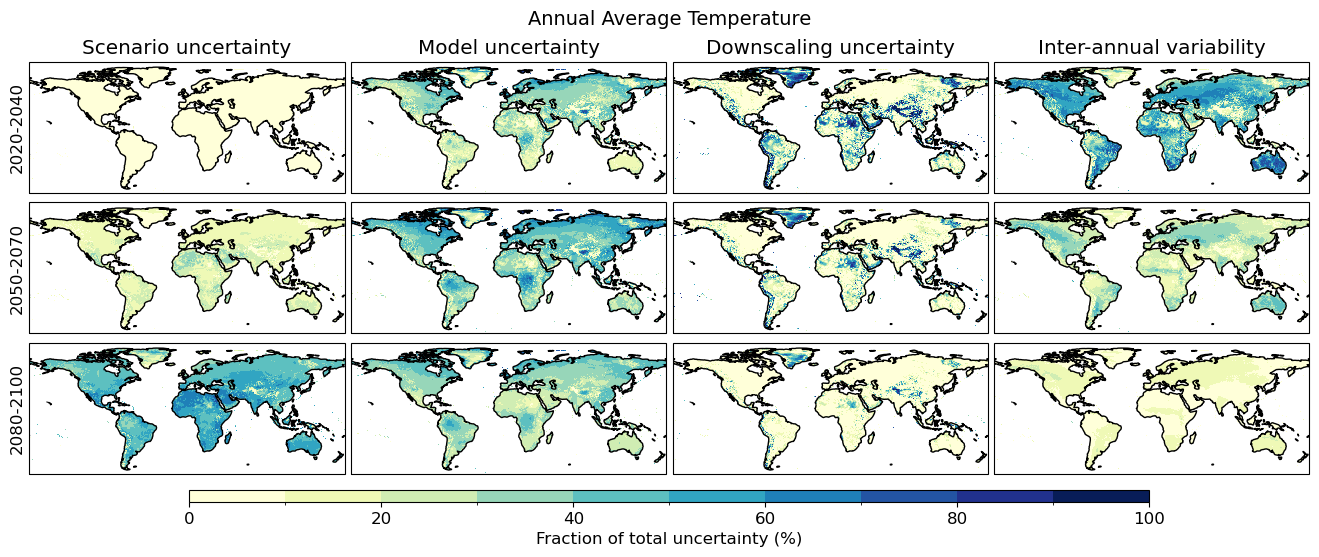

In [8]:
plot_map_iav(ds, 'tas', 'Annual Average Temperature', False)

In [9]:
# Read
ds_uc = xr.open_dataset(path_in + 'hs09_iav/annual_avgs.nc')

ds_iav = xr.open_dataset(path_in + 'hs09_iav/annual_avgs_iav.nc')
ds_iav = ds_iav.assign_coords(time = np.arange(2020,2097)).assign_coords(uncertainty = 'variability')

ds = xr.concat([ds_iav, ds_uc], dim='uncertainty')

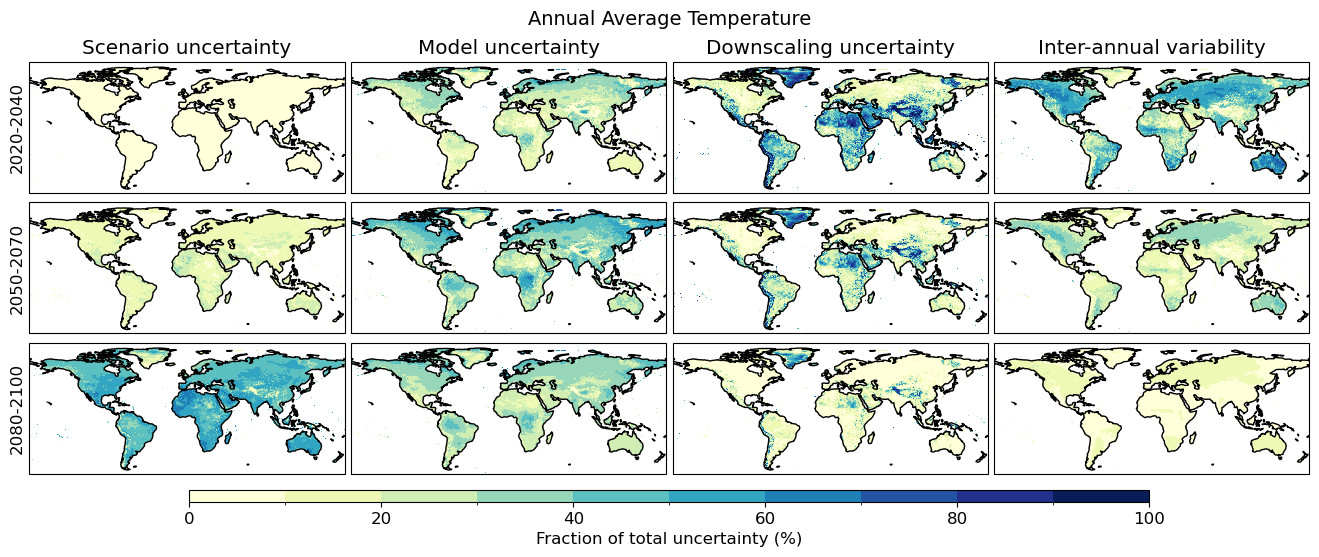

In [10]:
plot_map_iav(ds, 'tas', 'Annual Average Temperature', False)

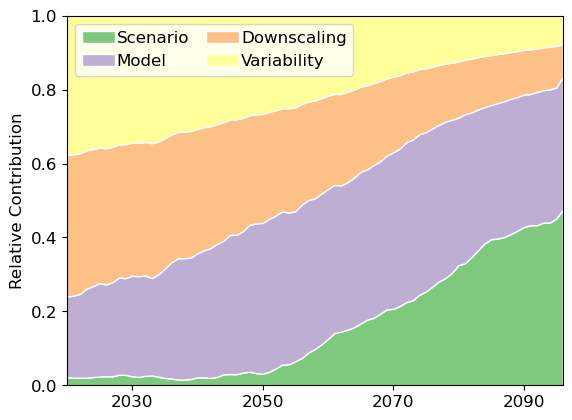

In [11]:
# Seattle
plot_single_point_iav(ds, 'tas', 47.6, -122.3)

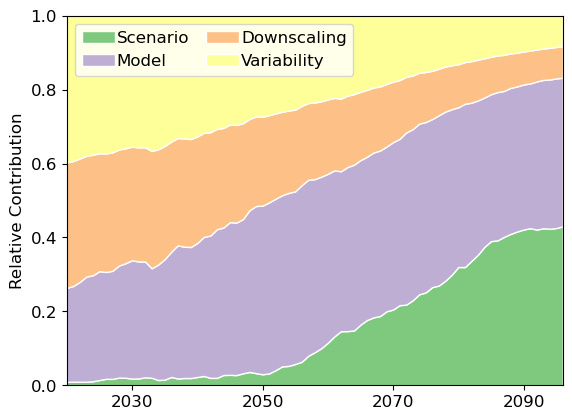

In [46]:
# Seattle
plot_single_point_iav(ds, 'tas', 47.6, -122.3)

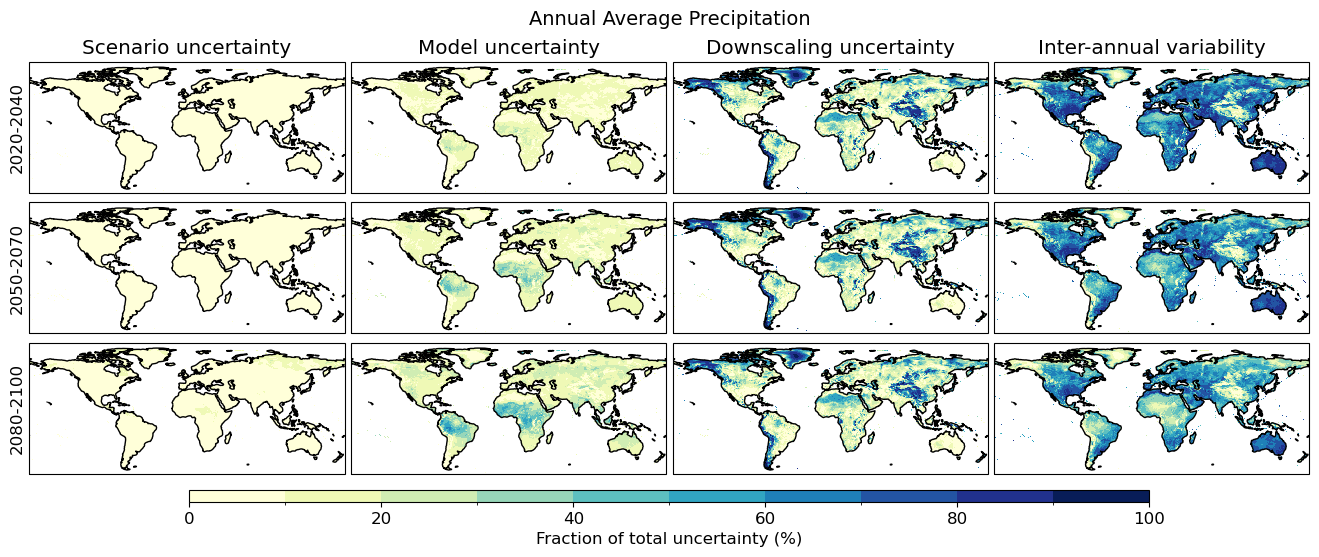

In [12]:
plot_map_iav(ds, 'pr', 'Annual Average Precipitation', False)

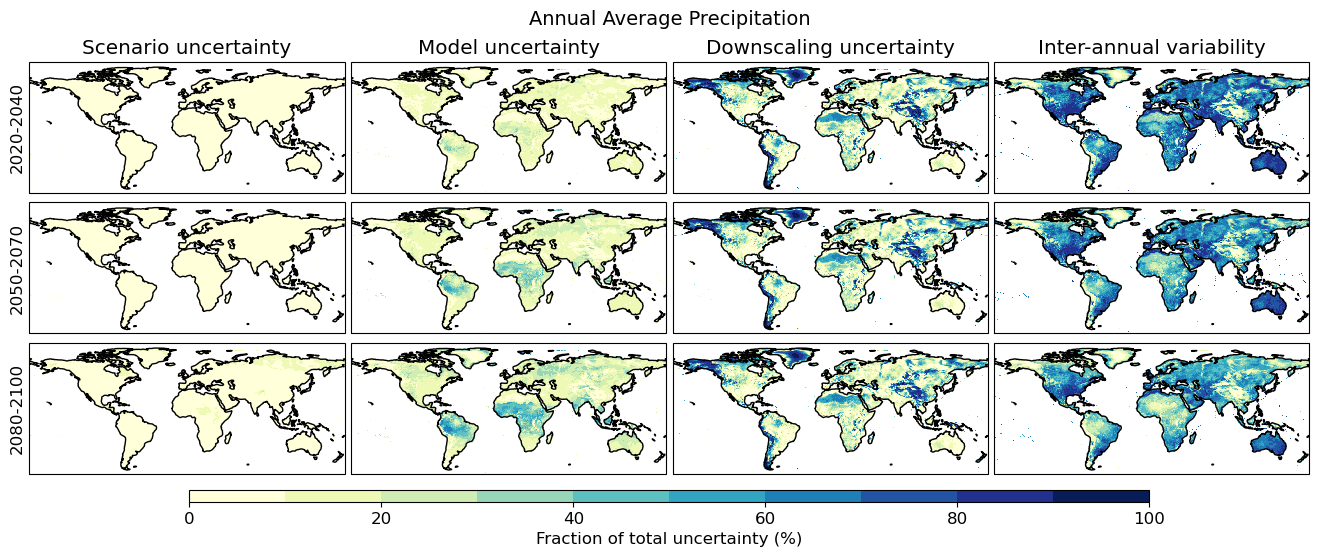

In [29]:
plot_map_iav(ds, 'pr', 'Annual Average Precipitation', False)

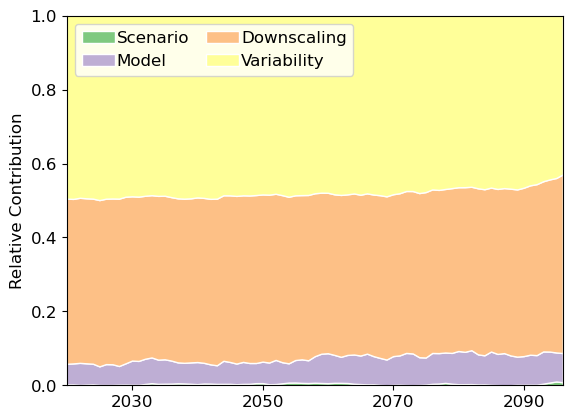

In [13]:
# Seattle
plot_single_point_iav(ds, 'pr', 47.6, -122.3)

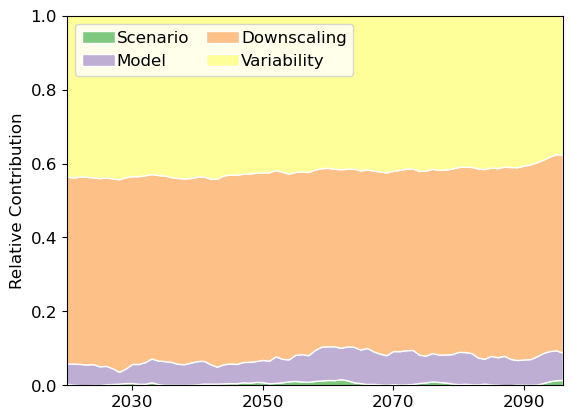

In [47]:
# Seattle
plot_single_point_iav(ds, 'pr', 47.6, -122.3)

### Annual maxs

In [48]:
# Read
ds = xr.open_dataset(path_in + 'annual_maxs_HS09_iav.nc')

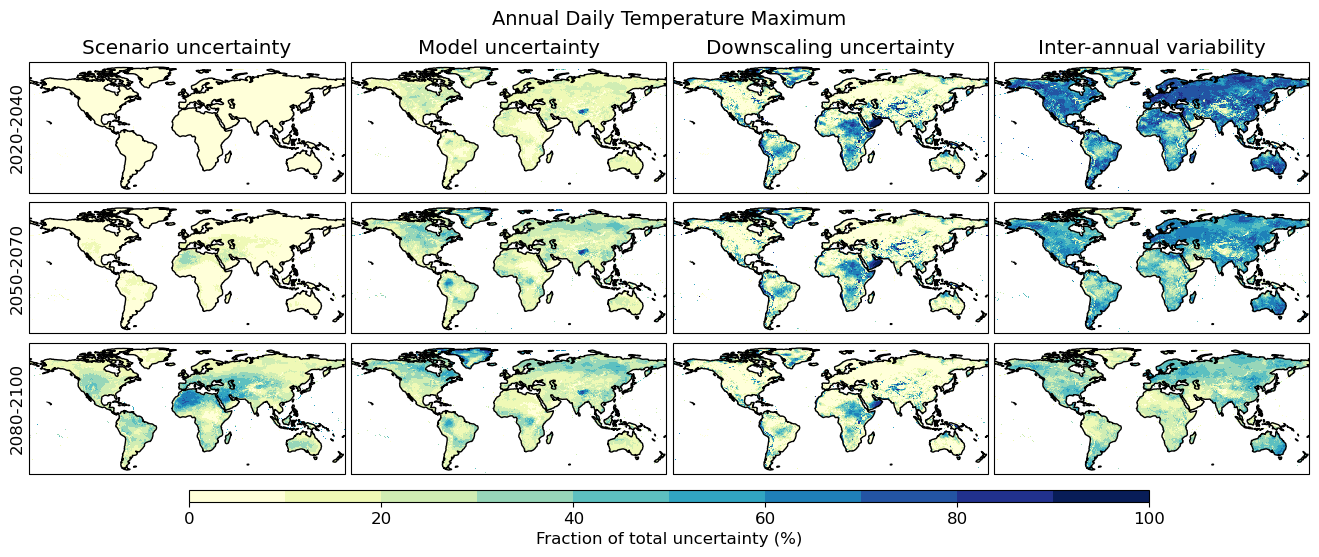

In [31]:
plot_map_iav(ds, 'tasmax', 'Annual Daily Temperature Maximum', False)

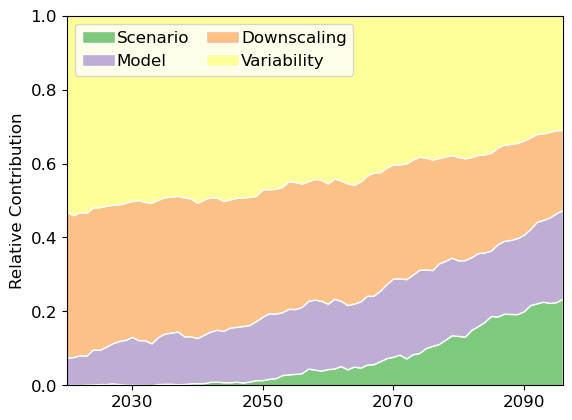

In [49]:
# Seattle
plot_single_point_iav(ds, 'tasmax', 47.6, -122.3)

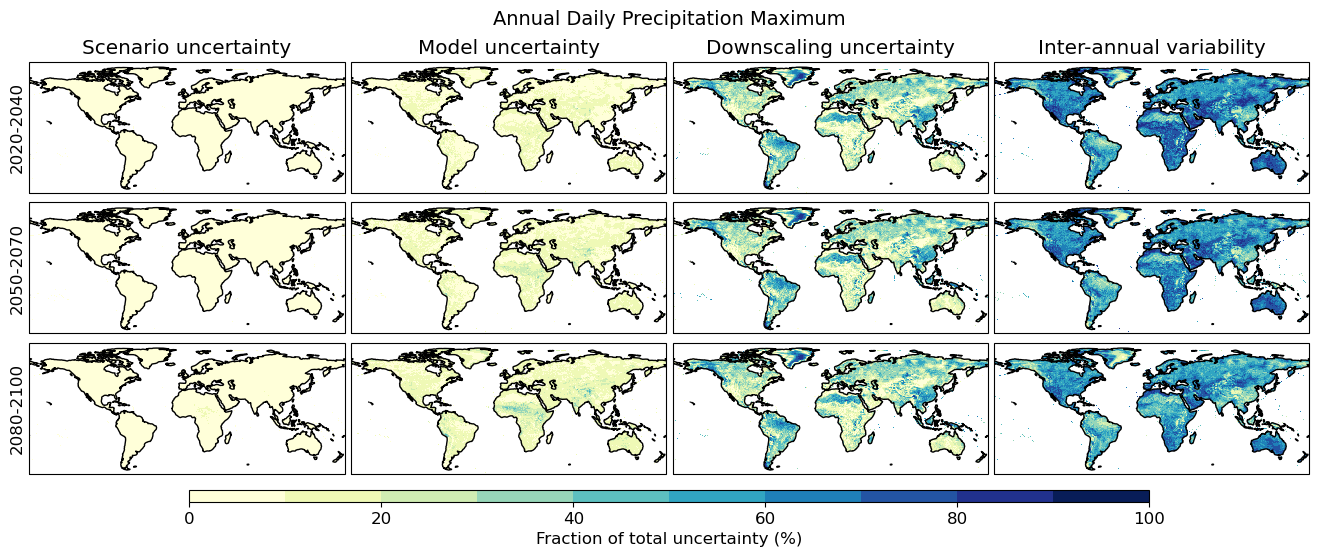

In [32]:
plot_map_iav(ds, 'pr', 'Annual Daily Precipitation Maximum', False)

In [50]:
# Seattle
plot_single_point_iav(ds, 'pr', 47.6, -122.3)

## No IAV

### Annual averages

In [23]:
# Read
ds = xr.open_dataset(path_in + 'annual_avgs_HS09.nc')

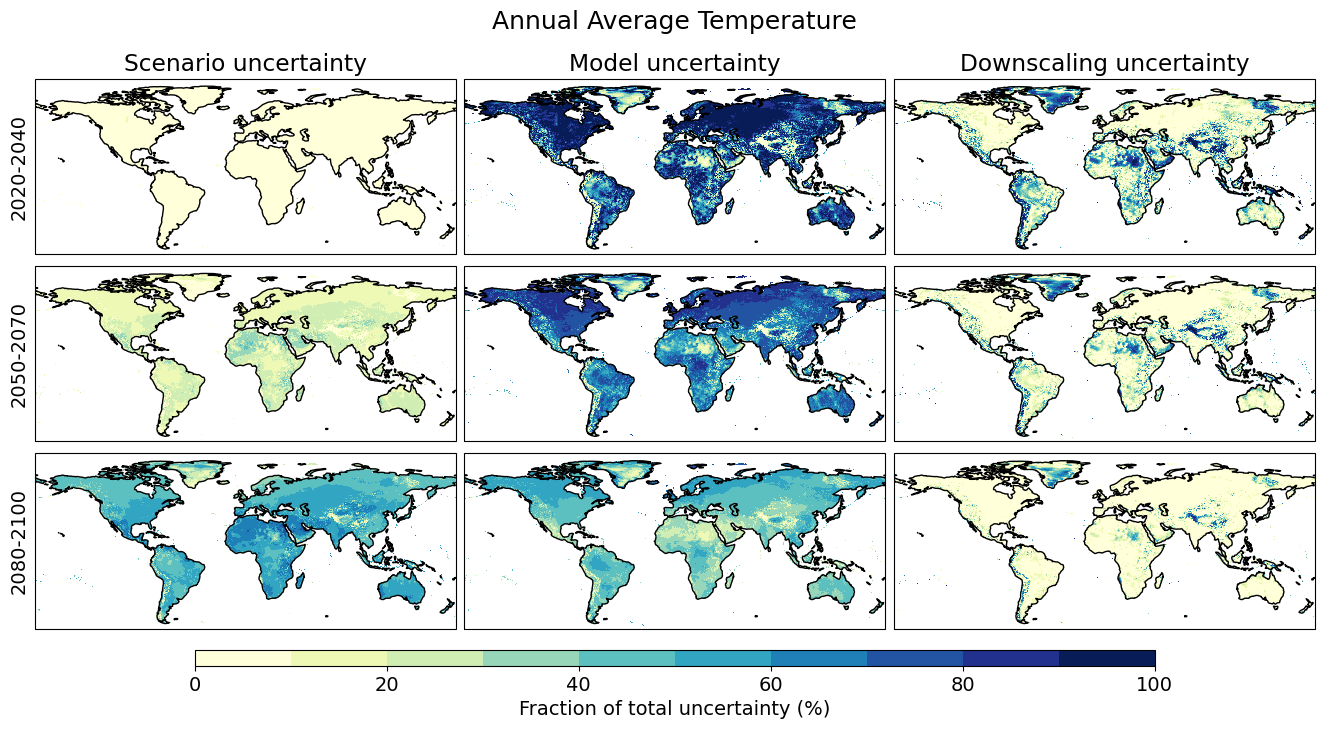

In [24]:
plot_map(ds, 'tas', 'Annual Average Temperature', 'tas_avg_hs09_map')

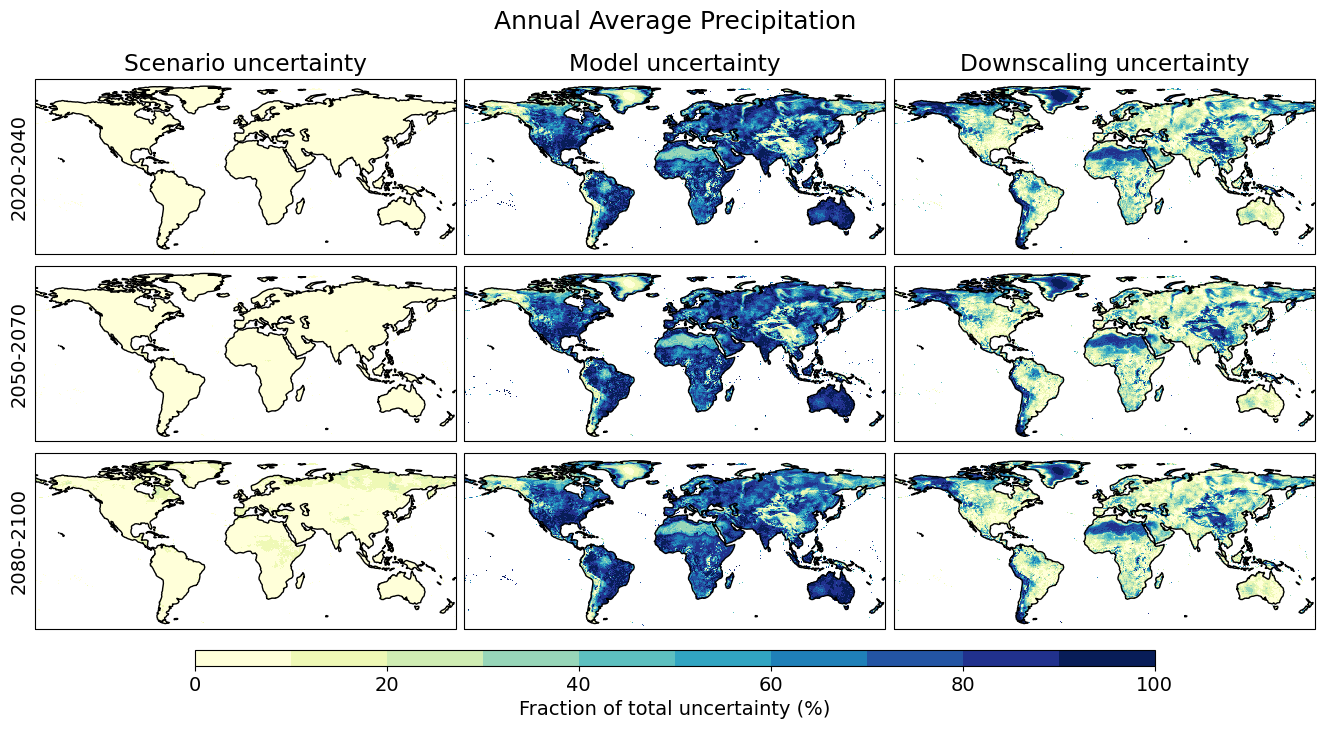

In [25]:
plot_map(ds, 'pr', 'Annual Average Precipitation', 'pr_avg_hs09_map')

## Annual maxs

In [26]:
# Read
ds = xr.open_dataset(path_in + 'annual_maxs_HS09.nc')

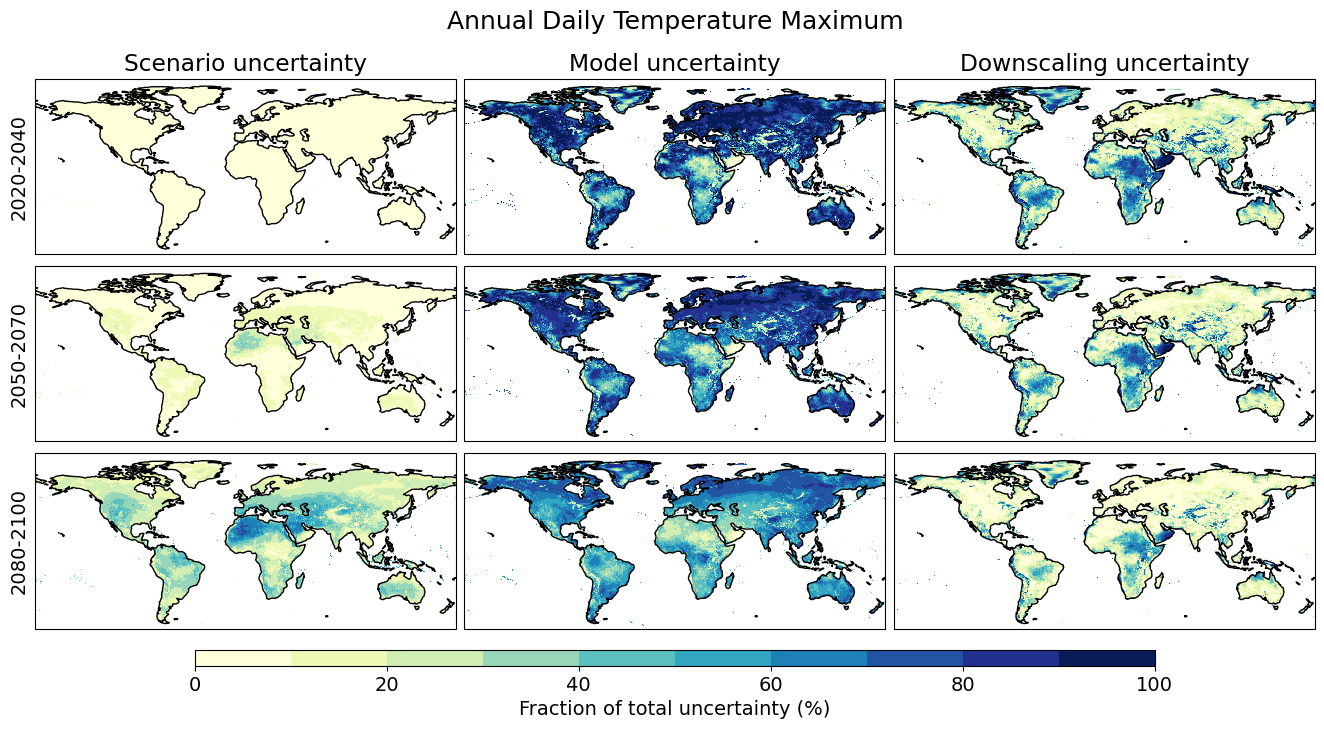

In [27]:
plot_map(ds, 'tasmax', 'Annual Daily Temperature Maximum', 'tasmax_max_hs09_map')

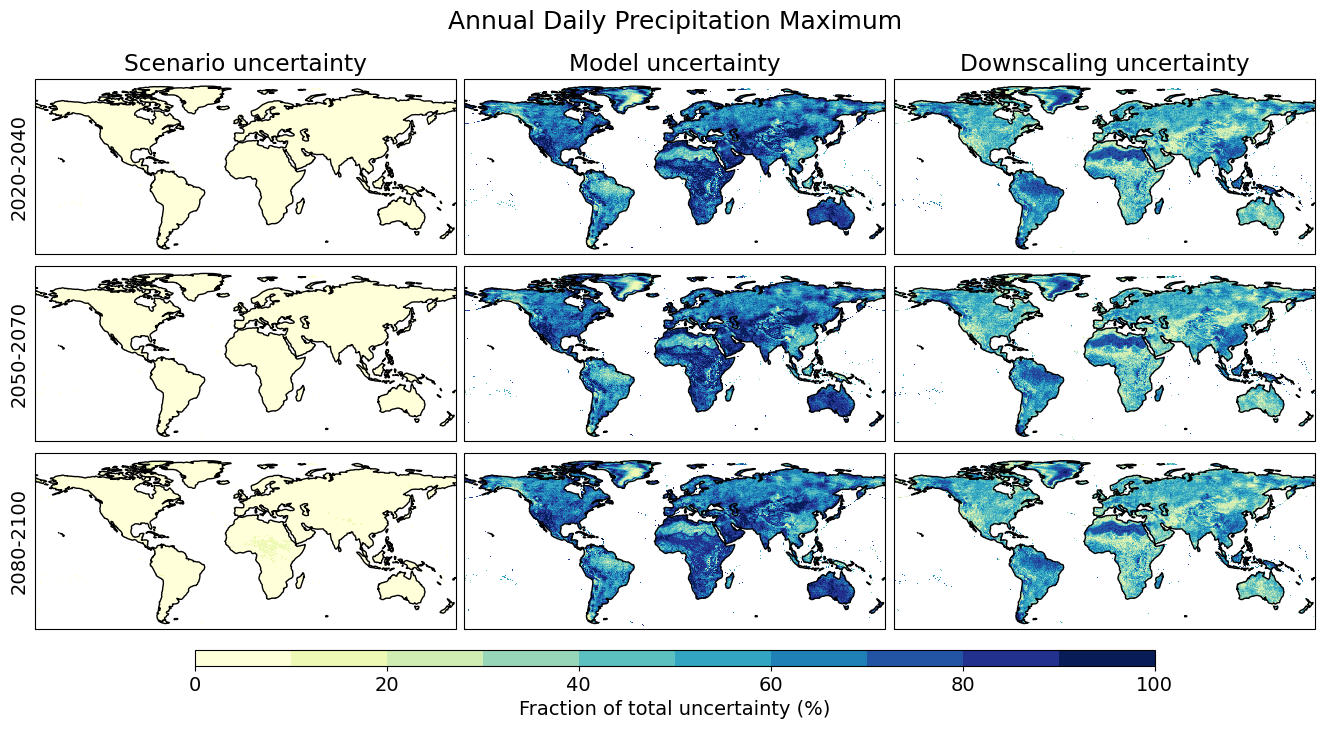

In [28]:
plot_map(ds, 'pr', 'Annual Daily Precipitation Maximum', 'pr_max_hs09_map')

## Testing

In [3]:
nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/cmip6/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/cmip6/cil-gdpcir/'

In [26]:
######################################
# Prep each ensemble for merge
######################################
def preprocess_nex(ds):
    ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
    ds = ds.sortby('lon')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(ensemble = 'NEX')
    ds = ds.assign_coords(model = ds.encoding['source'][93:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

def preprocess_cil(ds):
    if 'tasavg' in ds.data_vars:
        ds = ds.rename({'tasavg':'tas'})
    ds = ds.sel(lat=slice(-60, 90))
    ds = ds.assign_coords(ensemble = 'CIL')
    ds = ds.sortby('ssp')
    ds = ds.assign_coords(model = ds.encoding['source'][95:-3])
    ds['time'] = ds.indexes['time'].year
    return ds

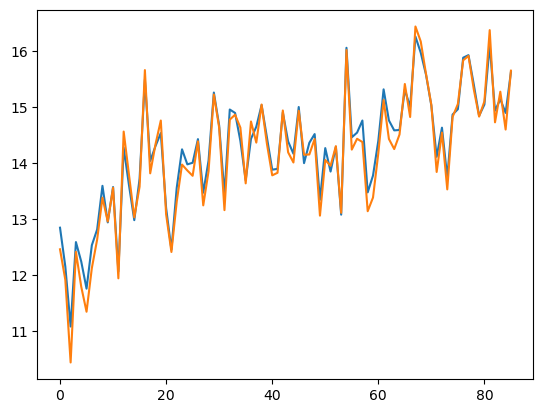

In [30]:
ds1 = preprocess_nex(xr.open_dataset(nex_in + 'annual_avgs/MIROC6.nc'))
ds2 = preprocess_cil(xr.open_dataset(cil_in + 'annual_avgs/MIROC6.nc'))

fig, ax = plt.subplots()
ax.plot(ds1.sel(ssp='ssp245').sel(lat = 40, lon = -88, method='nearest').tas.to_numpy())
ax.plot(ds2.sel(ssp='ssp245').sel(lat = 40, lon = -88, method='nearest').tas.to_numpy() - 273.15)
plt.show()

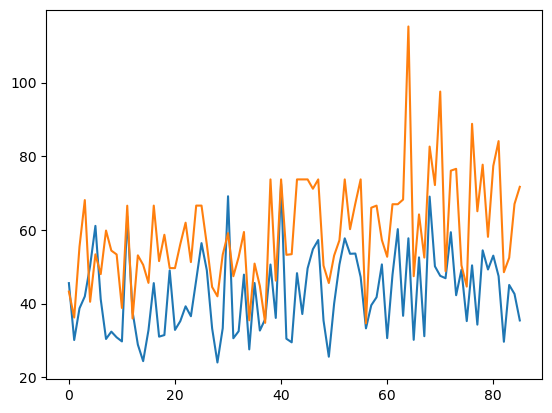

In [36]:
ds1 = preprocess_nex(xr.open_dataset(nex_in + 'annual_maxs/MIROC6.nc'))
ds2 = preprocess_cil(xr.open_dataset(cil_in + 'annual_maxs/MIROC6.nc'))

fig, ax = plt.subplots()
ax.plot(ds1.sel(ssp='ssp585').sel(lat = 40, lon = -88, method='nearest').pr.to_numpy())
ax.plot(ds2.sel(ssp='ssp585').sel(lat = 40, lon = -88, method='nearest').pr.to_numpy())
plt.show()